## Required module and library 

In [107]:
import pandas as pd
import numpy as np
from nltk import word_tokenize,sent_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.util import ngrams

## Loading the dataset 

In [108]:
df = pd.read_csv("fake_or_real_news.csv")


## Description of each column 

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [110]:
df['label'].value_counts()

label
REAL    3171
FAKE    3164
Name: count, dtype: int64

## Top 5 rows with longest title  

In [111]:
descending = df.sort_values(by='text', key=lambda x: x.str.len(), ascending=False)
descending['length_of_title']= descending['title'].str.len()
print(descending[:5])

      Unnamed: 0                                              title  \
4733        7910  Re: Why Are So Many People Choosing To Leave T...   
3436        5765  Re: It Is Now Mathematically Impossible To Pay...   
1359        5604  Benny Morris’s Untenable Denial of the Ethnic ...   
536         9618   President Putin Asks US To Stop Provoking Russia   
3685        8441  Re: America Has Become A Lawless Nation – Hill...   

                                                   text label  length_of_title  
4733  Why Are So Many People Choosing To Leave The U...  FAKE               75  
3436  It Is Now Mathematically Impossible To Pay Off...  FAKE               73  
1359  References The Debate \r\nIt started when Dani...  FAKE               68  
536   Here is President Putin’s speech at Valdai Put...  FAKE               48  
3685  America Has Become A Lawless Nation – Hillary ...  FAKE               86  


## Visualizing No. of real and fake news 

Text(0.5, 0, 'fake or real ')

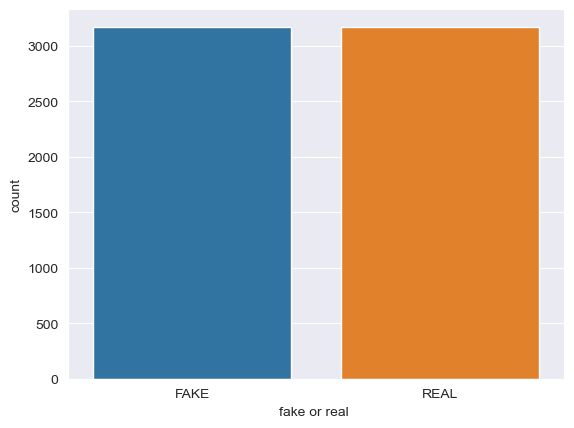

In [112]:
sns.countplot(x ='label',data = df)
plt.xlabel("fake or real ")

In [113]:
y = df.label

## Top 10 most frequent words in the data set 

Text(0, 0.5, 'count')

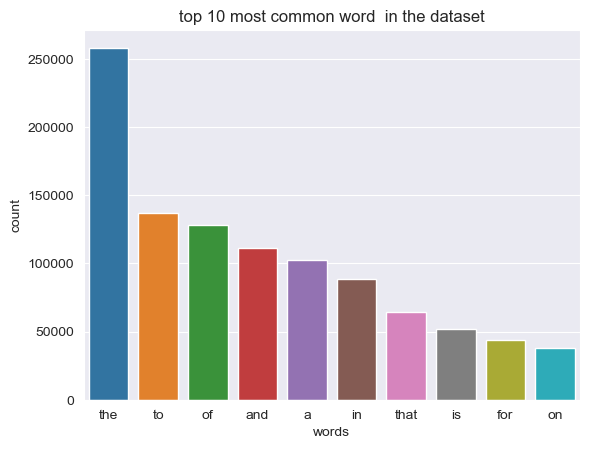

In [114]:

text= df['text'].str.split()
text_list = text.values.tolist()

corpus  = [word for i in text_list for word in i]
counter = Counter(corpus)
word,word_count  =  [],[]
most= counter.most_common()

for i,j in  most[:10]:
    word.append(i)
    word_count.append(j)

sns.barplot(x=word,y =word_count)
plt.title("top 10 most common word  in the dataset")
plt.xlabel("words")
plt.ylabel("count")


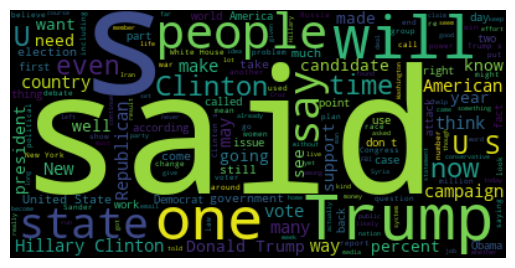

In [115]:

string_text = ' '.join(corpus)
stopwords = set(STOPWORDS)
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords).generate(string_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear' )
plt.axis("off")
plt.show()

## CountVectorizer

### bigram 

In [116]:
def get_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<Axes: >

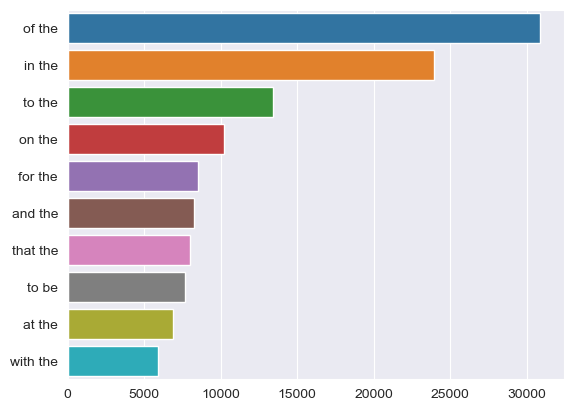

In [117]:
bigrams = get_ngram(df['text'],2)[:10]
x,y=map(list,zip(*bigrams))
sns.barplot(x=y,y=x)

## Trigram

<Axes: >

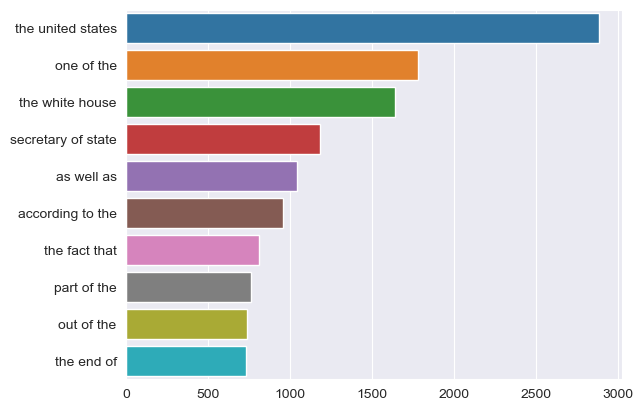

In [118]:
trigrams = get_ngram(df['text'],3)[:10]
x,y=map(list,zip(*trigrams))
sns.barplot(x=y,y=x)

### Creating training and test sets

In [119]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.33, random_state=53)

ValueError: Found input variables with inconsistent numbers of samples: [6335, 10]

### Initializing a CountVectorizer object: count_vectorizer

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')

### Transforming the training data using only the 'text' column values: count_train 

In [ ]:
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)


###  Printing the first 10 features 

In [ ]:
print(count_vectorizer.get_feature_names_out()[:10])

## TfidfVectorizer

### Initializing a TfidfVectorizer object: tfidf_vectorizer

In [ ]:

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)


### Transforming the training data: tfidf_train 

In [ ]:

tfidf_train = tfidf_vectorizer.fit_transform(X_train)
print(tfidf_train)

### Transform the test data: tfidf_test 

In [ ]:

tfidf_test = tfidf_vectorizer.transform(X_test)

### Printing the first 10 features

In [ ]:

print(tfidf_vectorizer.get_feature_names_out()[:10])

### Printing the first 5 vectors of the tfidf training data

In [ ]:

print(tfidf_train.A[:5])

### Creating the CountVectorizer DataFrame

In [ ]:

count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names_out())

### Creating the TfidfVectorizer DataFrame

In [ ]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names_out())

In [ ]:
# Print the head of count_df
print(count_df.head())

# Print the head of tfidf_df
print(tfidf_df.head())

# Calculate the difference in columns: difference
difference = set(count_df.columns) - set(tfidf_df.columns)
print(difference)

# Check whether the DataFrames are equal
print(count_df.equals(tfidf_df))


In [ ]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print(cm)

## Training and testing model with TfidfVectorizer

In [ ]:
# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)
# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE', 'REAL'])
print(cm)

## Checking the improvement to be made in the model 

In [ ]:
# Create the list of alphas: alphas
alphas = np.arange(0, 1, .1)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(tfidf_train, y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(tfidf_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()
    

## Model inspection 

In [ ]:
# Get the class labels: class_labels
class_labels = nb_classifier.classes_

# Extract the features: feature_names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.feature_log_prob_[0], feature_names))

# Print the first class label and the top 20 feat_with_weights entries
print(class_labels[0], feat_with_weights[:20])
print("")
# Print the second class label and the bottom 20 feat_with_weights entries
print(class_labels[1], feat_with_weights[-20:])

